<span style="color:blue"> 

# **Integrated Feature Engineering & PCA:**
</span> 

#### This notebook combines skill extraction with a PCA pipeline. The goal is to create a high-quality, feature-rich dataset ready for the final salary regression analysis.


***
## **Methodology:**

1. ####  **Text Cleaning & Preprocessing of Job Descriptions:**
   * will use this later to calculate TF-IDF scores which will use to create wordclouds for top keywords in HDBSCAN clusters

4. #### **Detailed Skill Extraction:**
    * Use a comprehensive lexicon, including specific Python libraries, to identify skills in each job description.

5. #### **Create a Categorical Seniority Column**
    * Searches for defined seniority keywords in job title and assigns a seniority level based off of this

5. #### **Discover job archetypes (K-Means Clustering on the Skills Matrix):**
    * Use K-means clustering with skills matrix to discover job archetypes
      
    * Here we use the **One-Hot Encoded Skill Matrix** DataFrame where each row is a job and each column is a skill (with a 1 or 0). This matrix is the perfect representation of a job's "technical DNA."

6. #### **One-Hot Encoding & Base Category Discussion:**
    * Convert the extracted skills and other categorical data into a numerical format.
    * Includes discussion and logic for deciding our base category for Region and K-means Job Archetype

7. #### **Principal Component Analysis (PCA):**
    * Use PCA on the detailed skill matrix to discover underlying "Super-Skill" groups, solving the problem of skill multicollinearity.


***

In [1]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.2 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
#Import necessary packages
import pandas as pd
import numpy as np
import re
import nltk

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.decomposition import PCA

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer

import matplotlib.pyplot as plt
import seaborn as sns
import spacy

nltk.download("stopwords")
nltk.download("wordnet")

# --- Load spaCy Model ---
try:
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    print("spaCy model 'en_core_web_sm' loaded successfully.")
except OSError:
    print("spaCy model 'en_core_web_sm' not found. Please run: python -m spacy download en_core_web_sm")

# Set plot style
sns.set_style('whitegrid')

[nltk_data] Downloading package stopwords to /Users/thomastrainor-
[nltk_data]     gilham/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/thomastrainor-
[nltk_data]     gilham/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


spaCy model 'en_core_web_sm' loaded successfully.


***
## --- Step 1: Load Job Listing Data & Clean Descriptions ---

In [6]:
# 1. Load cleaned master dataset

#PC: df = pd.read_csv(r"C:\Users\qq18295\OneDrive - University of Bristol\EwDS Dissertation\Data\Web Scraping\master_cleaned_job_listings_final_v2.csv")

df = pd.read_csv(r'/Users/thomastrainor-gilham/Library/CloudStorage/OneDrive-UniversityofBristol/EwDS Dissertation/Data/Web Scraping/master_cleaned_job_listings_final_v2.csv')
print(f"Shape of the dataset: {df.shape}")

Shape of the dataset: (4596, 19)


In [8]:
# --- 2. Text Cleaning / Preprocessing ---
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

# Clean text, display first few rows, and drop rows with no job description

df = df.dropna(subset=["job_description"]) # removes rows with missing descriptions
df["cleaned_desc"] = df["job_description"].apply(clean_text) # applies clean text to each function
display(df.head())
print(f"Shape of the dataset: {df.shape}")

source author date_posted  year                             job_title  \
0  Glassdoor    Tom  31/05/2025  2025          AI/ML Developer - AI Trainer   
1  Glassdoor    Tom  14/05/2025  2025          AI/ML Developer - AI Trainer   
2  Glassdoor    Tom  01/06/2025  2025  Business Intelligence (BI) Developer   
3  Glassdoor    Tom  03/05/2025  2025       Business Intelligence Developer   
4  Glassdoor    Tom  03/06/2025  2025                    Power BI Developer   

                                        company             location_raw  \
0                                DataAnnotation     Northampton, England   
1                                DataAnnotation     Northampton, England   
2  Northamptonshire Healthcare Foundation Trust       Kettering, England   
3                             Compass Fostering       Leicester, England   
4                                       Vero HR  Melton Mowbray, England   

                           salary_raw  \
0      Â£29.72Per hour(Employer Est.)   
1  Â£29.53Per hour(Employer provided)   
2    Â£46K - Â£53K(Employer provided)   
3        Â£45K - Â£50K(Employer Est.)   
4       Â£43K - Â£50K(Glassdoor Est.)   

                                     job_description         search_keyword  \
0  We are looking for proficient programmers to j...          data-engineer   
1  We are looking for proficient programmers to j...                     AI   
2  For further information on the advertised role...  business-intelligence   
3  About The RoleWe are looking for a Business In...           data-analyst   
4  About the RoleWe are the internal recruitment ...           data-analyst   

   location_raw_1 location_raw_2                   region salary_currency  \
0     Northampton        England  East Midlands (England)             GBP   
1     Northampton        England  East Midlands (England)             GBP   
2       Kettering        England  East Midlands (England)             GBP   
3       Leicester        England  East Midlands (England)             GBP   
4  Melton Mowbray        England  East Midlands (England)             GBP   

   salary_min  salary_max salary_period  median_annual_salary_gbp  \
0       29.72       29.72        hourly                   61817.6   
1       29.53       29.53        hourly                   61422.4   
2    46000.00    53000.00        annual                   49500.0   
3    45000.00    50000.00        annual                   47500.0   
4    43000.00    50000.00        annual                   46500.0   

   is_salary_imputed                                       cleaned_desc  
0              False  looking proficient programmer join team train ...  
1              False  looking proficient programmer join team train ...  
2              False  information advertised role please refer job d...  
3              False  rolewe looking business intelligence developer...  
4              False  rolewe internal recruitment partner client lea...

Shape of the dataset: (4596, 20)


In [9]:
print("Encoding text with Sentence-BERT...")
model = SentenceTransformer('all-MiniLM-L6-v2')
X_bert = model.encode(df["job_description"].tolist(), show_progress_bar=True)

Encoding text with Sentence-BERT...


Batches:   0%|          | 0/144 [00:00<?, ?it/s]

#### SBERT Embeddings Code Explanation:
* Loads a lightweight a pre-trained SBERT model (all-MiniLM-L6-v2 from the sentence-transformers library) to convert each skill-related sentence or phrase into a dense vector (e.g., 384 dimensions).

* ***For example, "Requires Python and SQL" and "Needs expertise in Python programming" will have similar embeddings due to semantic overlap***

* model.encode(...): turns each job description into a dense vector that captures context and meaning.

* X_bert: a list of 384-dimensional vectors (or 768 for other BERT models).


#### SBERT Advantages:

* Captures semantic similarity (e.g., "NLP" and "natural language processing" are grouped together).
* Better for handling paraphrased or contextually similar skill mentions.
* Ideal for clustering skills into meaningful categories.

#### SBERT Limitations:

* Requires more computational resources than TF-IDF.
* Cluster interpretation can be subjective and may need manual labeling.

In [12]:
import hdbscan

print("Finding clusters with HDBSCAN...")
#Tune min_cluster_size and min_samples

# min_cluster_size: The smallest size a cluster can be.
# min_samples: The number of samples in a neighborhood for a point to be considered as a core point.

clusterer_v3 = hdbscan.HDBSCAN(min_cluster_size=30, min_samples=1, cluster_selection_method='leaf', gen_min_span_tree=True)
df["hbdscan_cluster_v3"] = clusterer_v3.fit_predict(X_bert)

# Check HDBSCAN cluster sizes (cluster -1 is noise)
print("\nHDBSCAN V3 (leaf method) Cluster Sizes:")
print(df["hbdscan_cluster_v3"].value_counts())

Finding clusters with HDBSCAN...

HDBSCAN V3 (leaf method) Cluster Sizes:
hbdscan_cluster_v3
-1    4128
 3     113
 4     100
 2      64
 5      61
 1      60
 0      38
 6      32
Name: count, dtype: int64


#### "Noise" Doesn't Mean "Bad Data" — It Means "Diversity"
In the context of HDBSCAN, "noise" simply means that a data point (a job description) is not located in a dense enough region to be considered part of a stable cluster.

* **What this tells us about the UK Economics / Data Science job market:** The fact that *90% (4128/4596)* of relevant job listings are "noise" is a direct, data-driven discovery that the market is incredibly diverse. It is not neatly organized into a few simple categories. The majority of roles are either:
    * **Highly Specialised:** Combining skills in unique ways for a specific company or industry (e.g., "Geospatial Data Scientist for Agricultural Futures").
    * **Hybrid Roles:** Blending skills across traditional domains (e.g., a developer role that also requires econometrics).
    * **Poorly Defined:** Job ads with vague or generic descriptions. This definitely applies to the adzuna data where job descriptions are often very short and messy.

### UMAP Visualisation for HDBSCAN Clusters

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


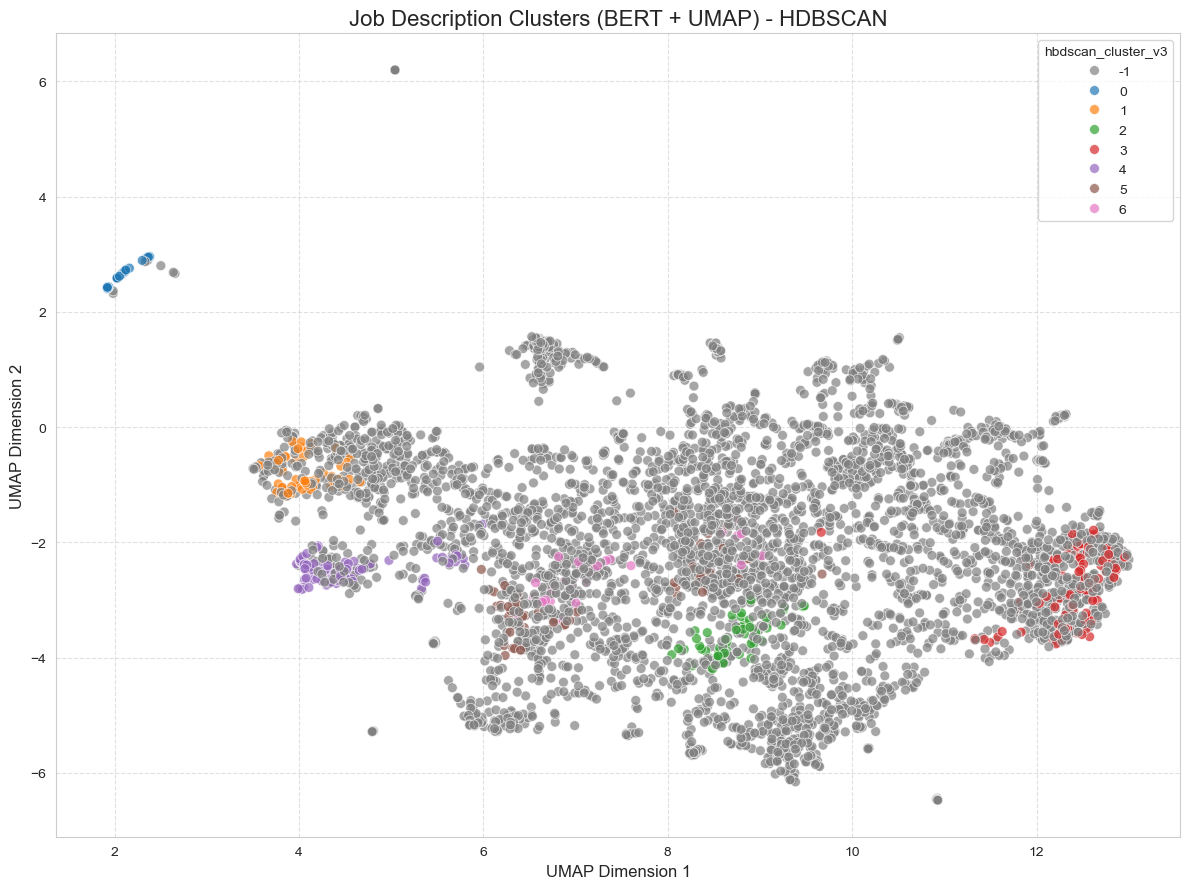

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap # Assuming you already have this imported and reducer fit

# Ensure df has 'umap_x', 'umap_y', and 'cluster_hdbscan' columns
# If you haven't run UMAP reduction again after getting the clusters, do so:

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_bert) # Make sure X_bert is available
df["umap_x"] = X_umap[:, 0]
df["umap_y"] = X_umap[:, 1]

# Get unique cluster labels
unique_clusters = sorted(df["hbdscan_cluster_v3"].unique())
palette = {}

# Create color palette (tab10 or extend it if you have >10 clusters)
base_colors = sns.color_palette("tab10", n_colors=len([c for c in unique_clusters if c != -1]))

for i, cluster in enumerate(unique_clusters):
    if cluster == -1:
        palette[cluster] = "grey"  # Set noise cluster (-1) to grey
    else:
        palette[cluster] = base_colors[i if -1 not in unique_clusters[:i] else i - 1]

# Plot
plt.figure(figsize=(12, 9))
sns.scatterplot(
    x="umap_x", y="umap_y",
    hue="hbdscan_cluster_v3",
    data=df,
    palette=palette,
    legend="full",
    s=50,
    alpha=0.7
)
plt.title("Job Description Clusters (BERT + UMAP) - HDBSCAN", fontsize=16)
plt.xlabel("UMAP Dimension 1", fontsize=12)
plt.ylabel("UMAP Dimension 2", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# After plotting, visually inspect:
# - Do the different colored groups appear distinct and separated?
# - Is the '-1' (noise) cluster widely scattered or does it form its own fuzzy region?
# - Do clusters that you think should be related appear closer together?

#### Interpretation of UMAP Plot:

* **Distinctness:** Look for clear separation between the different colored groups. If a cluster's points are tightly packed and far from other clusters, that indicates strong distinctness.
  
* **Overlap:** If colors heavily mix in certain regions, it suggests that those clusters are not well-separated in the embedding space, and their archetypes might overlap significantly.

  
* **Noise (-1):** Observe where the black/grey points (noise) are located. If they are scattered broadly or form a cloud around the main clusters, that's normal. If they seem to obscure clear clusters or form their own dense "blob," it might indicate issues or a very unique set of jobs.

### Word Clouds & Top Keywords for HDBSCAN Clusters

In [17]:
#To find the top keywords per HDBSCAN cluster we need to calculate TF-IDF scores to rank keywords
tfidf = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf.fit_transform(df["cleaned_desc"])

#### TF-IDF Code Explanation:
* TfidfVectorizer: Converts cleaned text into a matrix where each row is a job listing and each column is a term’s TF-IDF score

* max_features=1000: keeps the top 1000 most common words.

* X_tfidf: each row is a job description; each column is a word; values are weighted by frequency and importance.

#### TF-IDF Advantages:

* Simple and interpretable.
* Highlights skills that are distinctive to specific roles (e.g., "econometrics" for economics-heavy roles).
* Works well for keyword-based analysis.

#### TF-IDF Limitations:

* Ignores semantic relationships (e.g., "machine learning" and "deep learning" are treated as unrelated).
* Less effective for short texts or when skills are phrased differently (e.g., "statistical modeling" vs. "statistics").


--- Analyzing HDBSCAN Cluster 0 ---


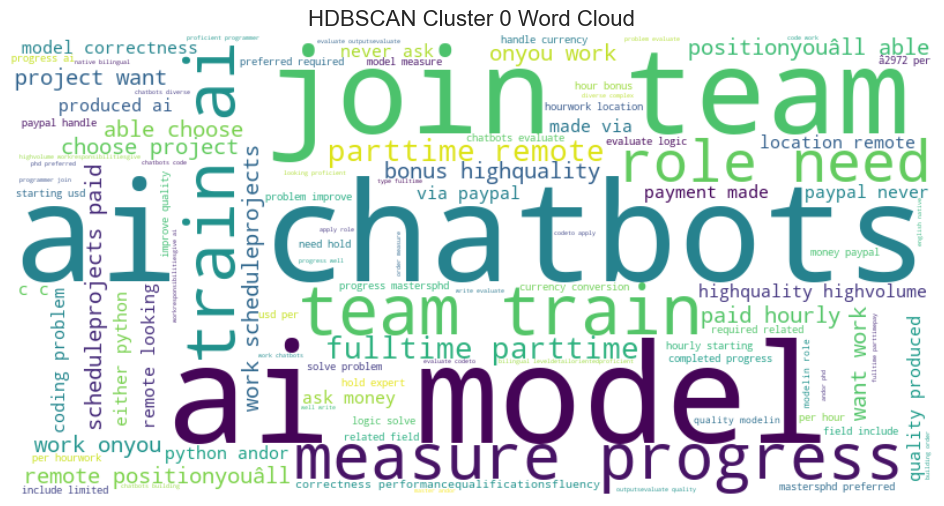


--- Analyzing HDBSCAN Cluster 1 ---


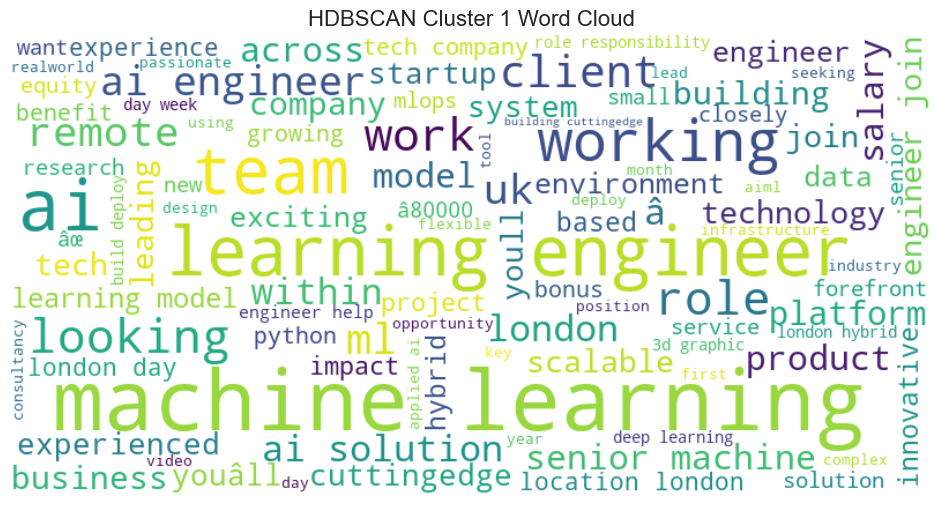


--- Analyzing HDBSCAN Cluster 2 ---


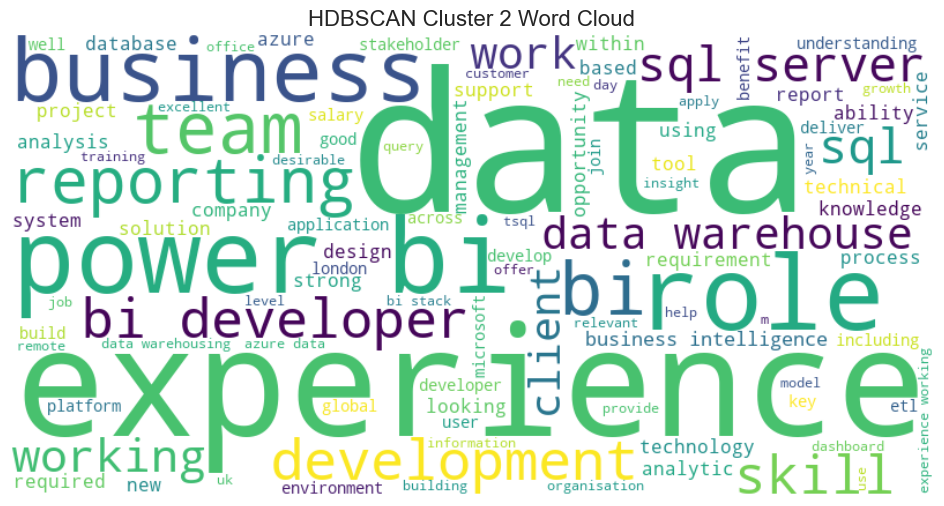


--- Analyzing HDBSCAN Cluster 3 ---


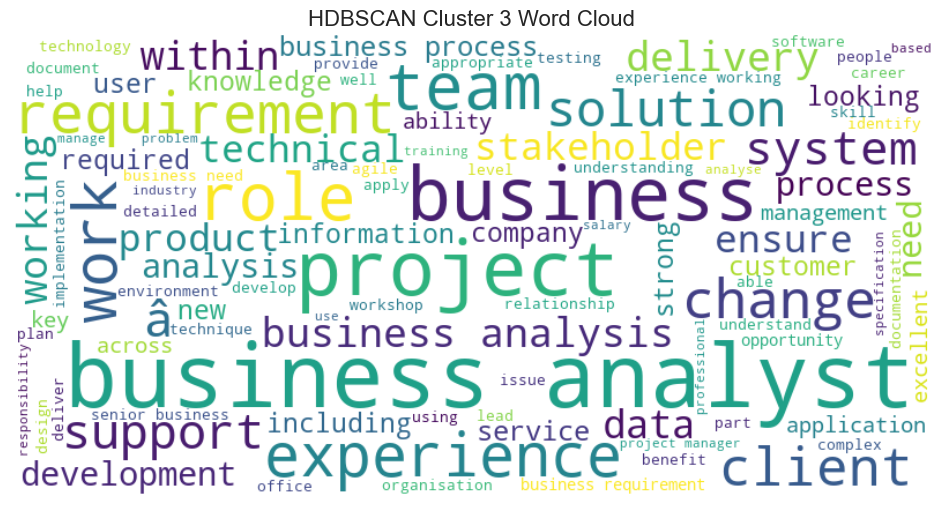


--- Analyzing HDBSCAN Cluster 4 ---


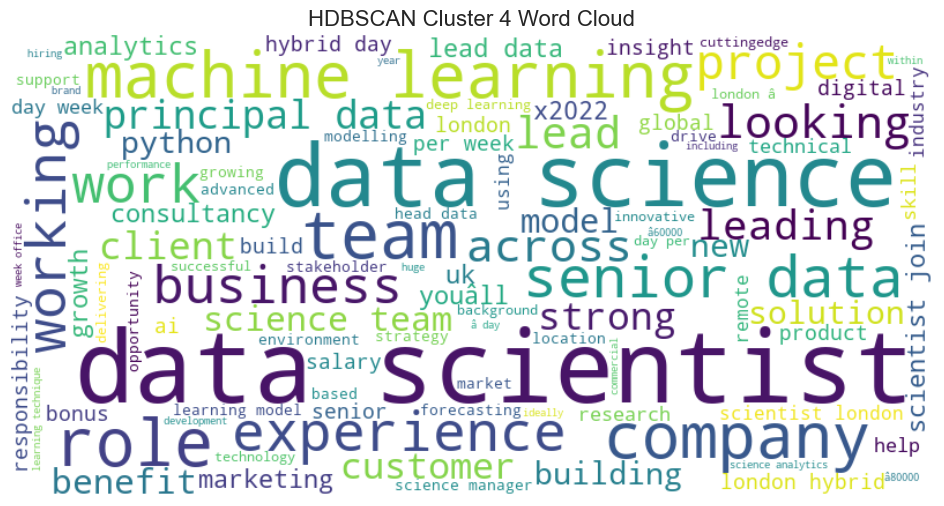


--- Analyzing HDBSCAN Cluster 5 ---


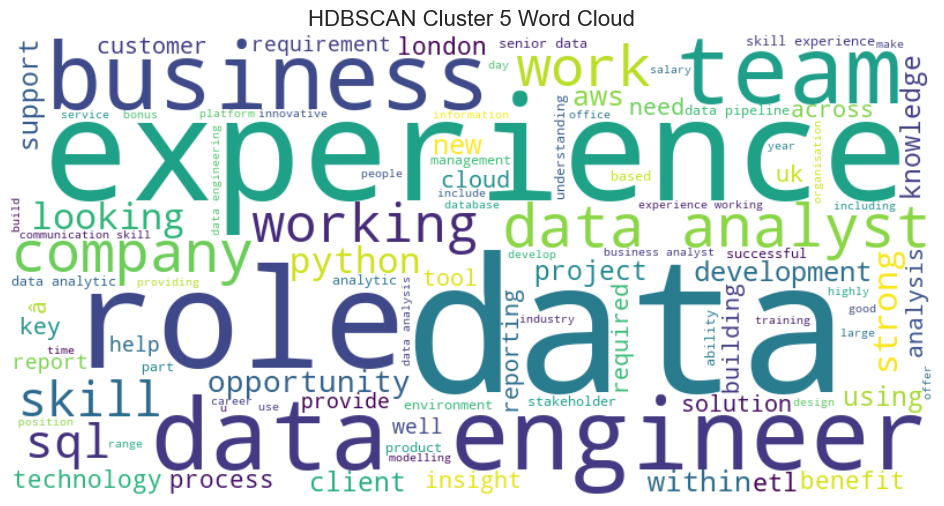


--- Analyzing HDBSCAN Cluster 6 ---


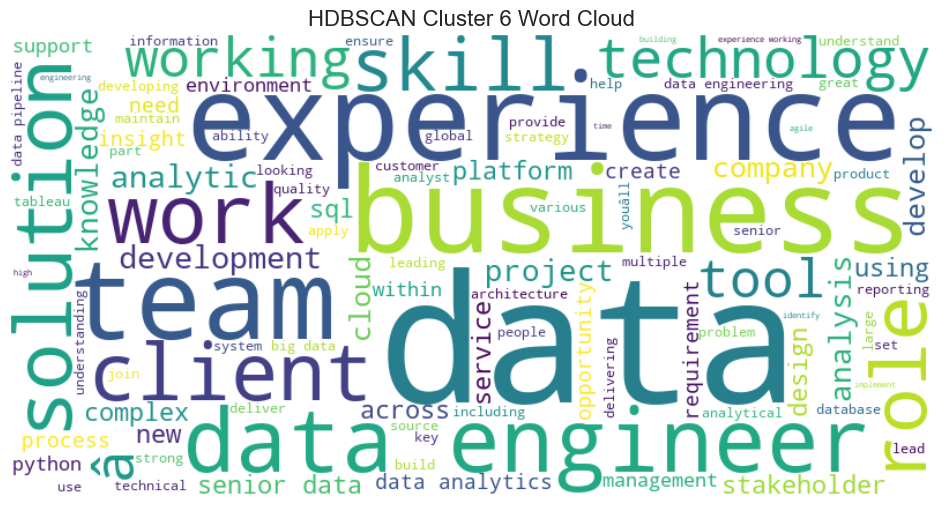

In [21]:
#To find the top keywords per HDBSCAN cluster we use TF-IDF scores for the keywords

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'cleaned_desc' and 'cluster_hdbscan' columns are in your DataFrame 'df'

# --- Create a DataFrame of TF-IDF features with HDBSCAN cluster labels ---
# This allows us to use the TF-IDF weights to find top keywords per HDBSCAN cluster.
tfidf_df_hdbscan = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df_hdbscan["cluster"] = df["hbdscan_cluster_v3"]

# --- Function to get top keywords per cluster (reusing your existing logic) ---
def top_keywords_hdbscan(cluster_df, n=10):
    # Exclude the 'cluster' column itself from the mean calculation
    if 'cluster' in cluster_df.columns:
        return (
            cluster_df.drop("cluster", axis=1)
            .mean()
            .sort_values(ascending=False)
            .head(n)
        )
    else:
        return (
            cluster_df.mean()
            .sort_values(ascending=False)
            .head(n)
        )

# --- Loop through unique HDBSCAN clusters (excluding noise -1) ---
clusters_to_analyze = sorted([c for c in df["hbdscan_cluster_v3"].unique() if c != -1])

for cluster_id in clusters_to_analyze:
    print(f"\n--- Analyzing HDBSCAN Cluster {cluster_id} ---")

    # 1. Word Cloud
    # Filter the original DataFrame for descriptions belonging to this cluster
    cluster_texts = df[df["hbdscan_cluster_v3"] == cluster_id]["cleaned_desc"]
    if not cluster_texts.empty:
        text_for_wordcloud = " ".join(cluster_texts.astype(str))
        wc = WordCloud(width=800, height=400, background_color="white",
                       max_words=100, contour_width=3, contour_color='steelblue').generate(text_for_wordcloud)

        plt.figure(figsize=(12, 6))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"HDBSCAN Cluster {cluster_id} Word Cloud", fontsize=16)
        plt.show()
    else:
        print(f"No text found for Cluster {cluster_id}")

In [22]:
# --- Display top keywords for each unique HDBSCAN clusters (excluding noise -1) ---
clusters_to_analyze = sorted([c for c in df["hbdscan_cluster_v3"].unique() if c != -1])

for cluster_id in clusters_to_analyze:
    print(f"\n--- Analyzing HDBSCAN Cluster {cluster_id} ---")

    # 1. Get cluster size
    cluster_size = (df["hbdscan_cluster_v3"] == cluster_id).sum()
    print(f"\nHDBSCAN Cluster {cluster_id} Size: {cluster_size}")

    # 2. Top Keywords
    # Filter the HDBSCAN features DataFrame for descriptions belonging to this cluster
    cluster_tfidf_data = tfidf_df_hdbscan[tfidf_df_hdbscan["cluster"] == cluster_id]
    if not cluster_tfidf_data.empty:
        print(f"\n🔹 Top words in HDBSCAN Cluster {cluster_id}:")
        print(top_keywords_hdbscan(cluster_tfidf_data))
    else:
        print(f"\nNo TF-IDF data found for HDBSCAN Cluster {cluster_id}")


--- Analyzing HDBSCAN Cluster 0 ---

HDBSCAN Cluster 0 Size: 38

🔹 Top words in HDBSCAN Cluster 0:
ai             0.275884
progress       0.235425
evaluate       0.190313
problem        0.156218
per            0.148105
measure        0.142293
model          0.139650
quality        0.137396
andor          0.136157
highquality    0.133997
dtype: float64

--- Analyzing HDBSCAN Cluster 1 ---

HDBSCAN Cluster 1 Size: 60

🔹 Top words in HDBSCAN Cluster 1:
ai             0.250293
engineer       0.219532
machine        0.203573
learning       0.187474
london         0.082455
ml             0.070525
cuttingedge    0.055715
team           0.054706
tech           0.053447
model          0.051775
dtype: float64

--- Analyzing HDBSCAN Cluster 2 ---

HDBSCAN Cluster 2 Size: 64

🔹 Top words in HDBSCAN Cluster 2:
bi            0.372761
data          0.168030
power         0.142751
sql           0.122507
developer     0.118679
ssis          0.093218
server        0.090052
business      0.079945
experi

In [23]:
# --- Define Job Archetype Names for HDBSCAN Clusters ---

# I plugged top keywords into an LLM and asked them to come up with a job archetype based on the keywords

# Based on word cloud and top keyword analysis for each HDBSCAN cluster:
HDBSCAN_ARCHETYPE_NAMES = {
    -1: "Unclassified/Noise",
    0: "ML Model Evaluation & Quality Engineer",
    1: "Machine Learning Engineer",
    2: "BI / Data Platform Developer",
    3: "Business / Process Analyst",
    4: "Data Scientist",
    5: "Data Engineer / ETL Specialist",
    6: "Analytics Engineer / Client-Facing Data Specialist",
}

# --- Attach Archetype Names to HDBSCAN Clusters ---
if 'hbdscan_cluster_v3' in df.columns:
    df['hdbscan_job_archetype'] = df['hbdscan_cluster_v3'].map(HDBSCAN_ARCHETYPE_NAMES)
    print("Added 'hdbscan_job_archetype' column.")
else:
    print("Column 'hbdscan_cluster_v3' not found in DataFrame. Skipping HDBSCAN archetype mapping.")

# --- Display a sample of the DataFrame with new columns ---
print("\nDataFrame head with new archetype columns:")
df[['job_title', 'hbdscan_cluster_v3', 'hdbscan_job_archetype']].head()

Added 'hdbscan_job_archetype' column.

DataFrame head with new archetype columns:


job_title  hbdscan_cluster_v3  \
0          AI/ML Developer - AI Trainer                   0   
1          AI/ML Developer - AI Trainer                   0   
2  Business Intelligence (BI) Developer                  -1   
3       Business Intelligence Developer                  -1   
4                    Power BI Developer                   2   

                    hdbscan_job_archetype  
0  ML Model Evaluation & Quality Engineer  
1  ML Model Evaluation & Quality Engineer  
2                      Unclassified/Noise  
3                      Unclassified/Noise  
4            BI / Data Platform Developer

***
## --- Step 2: Define the Skill Lexicon (informed by SkillsBuild Modules)---

In [25]:
# We define skills with variations and use regex patterns for accuracy.
# The key is the canonical skill name, the value is a list of regex patterns.
# The \b ensures we match whole words only.

# I decided to exclude soft skills as while they are undeniably critical for a successful career, they 
# are not good features for a quantitative salary prediction model because they are too common and too 
# ambiguous to measure effectively from a job ad. 

# They are better discussed qualitatively when describing Job Archetypes.

TECHNICAL_SKILLS = {
    'Python': [r'\bpython\b', r'jupyter'],
    'R': [r'\br\b'],
    'SQL': [r'sql'],
    'Excel': [r'\bexcel\b'],
    'Tableau': [r'\btableau\b'],
    'Power BI': [r'\bpower bi\b', r'\bpowerbi\b'],
    'AWS': [r'\baws\b', r'amazon web services'],
    'Azure': [r'\bazure\b', r'azure'],
    'GCP': [r'\bgcp\b', r'google cloud platform'],
    'Spark': [r'\bspark\b'],
    'Hadoop': [r'\bhadoop\b'],
    'Java': [r'\bjava\b'],
    'C++': [r'\bc\+\+\b'],
    'JavaScript': [r'\bjavascript\b'],
    'Git': [r'\bgit\b'],
    'Docker': [r'\bdocker\b'],
    'Kubernetes': [r'\bkubernetes\b'],
    'SAS': [r'\bsas\b'],
    'Machine Learning': [r'machine learning', r'\bml\b'],
    'Data Science': [r'data science'],
    'Statistics': [r'statistics', r'statistical'],
    'Economics': [r'economics', r'economical'],
    'Econometrics': [r'econometrics'],
    'AI': [r'\bai\b', r'artificial intelligence'],
    'Big Data': [r'big data', r'scraping'],
    'LLM': [r'large language models', r'chatgpt'], # Lowercased ChatGPT
    'Data Visualisation': [r'visualisation', r'data visualisation', r'data visualization'], # Added US spelling
    'Forecasting': [r'forecasting'],
    'A/B Testing': [r'A/B testing', r'ab testing'], # Added lowercase and with/without slash

    # --- ALL POTENTIAL PYTHON LIBRARIES ---
    'Pandas': [r'\bpandas\b'],
    'NumPy': [r'\bnumpy\b'],
    'Matplotlib': [r'\bmatplotlib\b'],
    'Seaborn': [r'\bseaborn\b'],
    'Plotly': [r'\bplotly\b'],
    'Dash': [r'\bdash\b'],
    'FastAPI': [r'\bfastapi\b'],
    'Flask': [r'\bflask\b'],
    'Django': [r'\bdjango\b'],
    'SQLAlchemy': [r'sqlalchemy'],
    'Scikit-learn': [r'scikit-learn', r'\bsklearn\b'],
    'TensorFlow': [r'\btensorflow\b'],
    'PyTorch': [r'\bpytorch\b'],
    'Airflow': [r'\bairflow\b'],
    'Prefect': [r'\bprefect\b'],
    'Dask': [r'\bdask\b'],
    'SciPy': [r'\bscipy\b'],
    'Statsmodels': [r'\bstatsmodels\b'],
    'XGBoost': [r'\bxgboost\b'],
    'LightGBM': [r'\blightgbm\b'],
    'Kafka': [r'\bkafka\b'],
    'Celery': [r'\bcelery\b'],
    'BeautifulSoup': [r'beautifulsoup', r'bs4'],
    'Requests': [r'\brequests\b'],
    'NLTK': [r'\bnltk\b'],
    'SpaCy': [r'\bspacy\b']
}

SOFT_SKILLS = {
    'Communication': [r'\bcommunication\b', r'\bcommunications\b', r'\bcommunicate\b'],
    'Teamwork': [r'teamwork', r'team player', r'team-player'],
    'Collaboration': [r'\bcollaboration\b', r'\bcollaborative\b'],
    'Problem Solving': [r'problem solving', r'problem-solving', r'problem solve'],
    'Analysis': [r'\banalytical\b', r'\banalyze\b', r'\banalyse\b'],
    'Leadership': [r'\bleadership\b', r'\blead\b'],
    'Stakeholder Management': ['stakeholder management', 'managing stakeholders'],
    'Presentation': [r'\bpresentation\b', r'\bpresenting\b', r'\bpresent\b'],
    'Project Management': ['project management', 'project manage'],
    'Agile': [r'\bagile\b']
}

In [28]:
def extract_technical_skills(text):
    """Searches for skills from the comprehensive lexicon in a given text."""
    found_tech_skills = set()
    text_lower = str(text).lower()
    for skill, patterns in TECHNICAL_SKILLS.items():
        for pattern in patterns:
            if re.search(pattern, text_lower):
                found_tech_skills.add(skill)
                break
    return list(found_tech_skills)

def extract_soft_skills(text):
    """Searches for skills from the comprehensive lexicon in lemmatized text."""
    found_soft_skills = set()
    raw_text = str(text).lower()
    doc = nlp(raw_text)
    lemmatized_text = ' '.join([token.lemma_ for token in doc])

    for skill, patterns in SOFT_SKILLS.items():
        for pattern in patterns:
            if re.search(pattern, lemmatized_text):
                found_soft_skills.add(skill)
                break
    return list(found_soft_skills)

df['technical_skills'] = df['job_description'].apply(extract_technical_skills)
df['soft_skills'] = df['job_description'].apply(extract_soft_skills)


print("Skill extraction complete. Example:")
display(df[['job_title', 'technical_skills', 'soft_skills']].head())

Skill extraction complete. Example:


job_title  \
0          AI/ML Developer - AI Trainer   
1          AI/ML Developer - AI Trainer   
2  Business Intelligence (BI) Developer   
3       Business Intelligence Developer   
4                    Power BI Developer   

                        technical_skills                 soft_skills  
0    [Python, Java, AI, JavaScript, SQL]                          []  
1    [Python, Java, AI, JavaScript, SQL]                          []  
2                                     []                          []  
3  [Azure, Requests, Git, SQL, Power BI]             [Communication]  
4                   [Power BI, AWS, SQL]  [Leadership, Presentation]

***

# --- Step 3: Discover Job Archetypes with *K-Means Clustering on the Skill Matrix* ---

* Here we use the **One-Hot Encoded Skill Matrix** DataFrame where each row is a job and each column is a skill (with a 1 or 0). This matrix is the perfect representation of a job's "technical DNA."

* **Use K-Means, Not HDBSCAN:** For this type of binary, high-dimensional data, K-Means is often more effective and easier to tune. It will force every job into a cluster, eliminating the "noise" problem and giving you clean groups.

* **Find the Optimal k:** We use the Elbow Method or Silhouette Score on the skill matrix to find the best number of clusters (k). This will be much more reliable than it was on the SBERT embeddings.


In [37]:
# --- First we One-Hot Encode Skills to create a technical skill matrix ---
mlb = MultiLabelBinarizer()
skill_matrix = pd.DataFrame(mlb.fit_transform(df['technical_skills']),
                            columns=mlb.classes_,
                            index=df.index)
print(f"Created technical skill matrix with shape: {skill_matrix.shape}")
display(skill_matrix.head())

Created technical skill matrix with shape: (4596, 54)


A/B Testing  AI  AWS  Airflow  Azure  BeautifulSoup  Big Data  C++  Celery  \
0            0   1    0        0      0              0         0    0       0   
1            0   1    0        0      0              0         0    0       0   
2            0   0    0        0      0              0         0    0       0   
3            0   0    0        0      1              0         0    0       0   
4            0   0    1        0      0              0         0    0       0   

   Dash  ...  SciPy  Scikit-learn  Seaborn  SpaCy  Spark  Statistics  \
0     0  ...      0             0        0      0      0           0   
1     0  ...      0             0        0      0      0           0   
2     0  ...      0             0        0      0      0           0   
3     0  ...      0             0        0      0      0           0   
4     0  ...      0             0        0      0      0           0   

   Statsmodels  Tableau  TensorFlow  XGBoost  
0            0        0           0        0  
1            0        0           0        0  
2            0        0           0        0  
3            0        0           0        0  
4            0        0           0        0  

[5 rows x 54 columns]

Finding optimal k using the Elbow Method...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


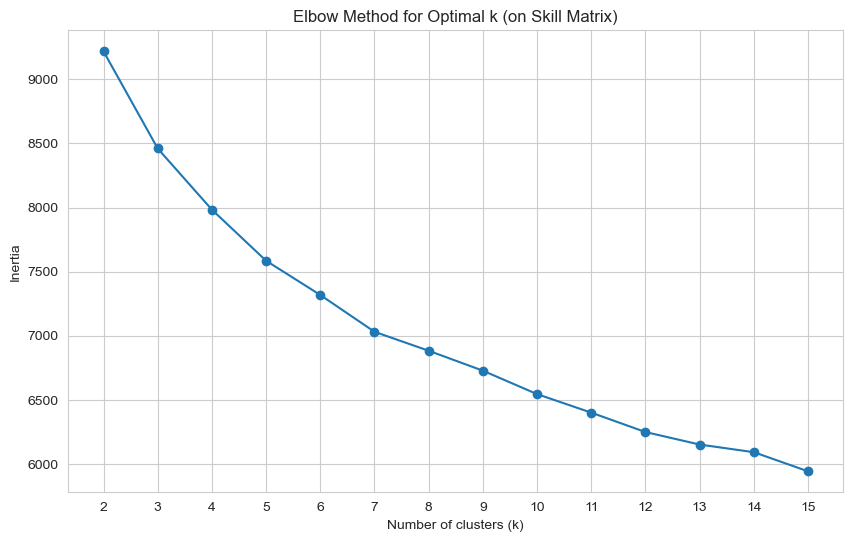

In [39]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# --- Find the optimal k for K-Means ---
print("Finding optimal k using the Elbow Method...")
inertia = []
k_range = range(2, 16) # Test k from 2 to 15

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init suppresses a warning
    kmeans.fit(skill_matrix)
    inertia.append(kmeans.inertia_)

# Plot the elbow
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k (on Skill Matrix)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

#### *** No Clear elbow- proceed with calculating Silhouette Scores to determine Optimal K

Calculating Silhouette Scores for different values of k...
k=2, Silhouette Score: 0.3084
k=3, Silhouette Score: 0.2316
k=4, Silhouette Score: 0.2074
k=5, Silhouette Score: 0.2281
k=6, Silhouette Score: 0.2305
k=7, Silhouette Score: 0.2328
k=8, Silhouette Score: 0.2246
k=9, Silhouette Score: 0.2412
k=10, Silhouette Score: 0.2448
k=11, Silhouette Score: 0.2541
k=12, Silhouette Score: 0.2590
k=13, Silhouette Score: 0.2606
k=14, Silhouette Score: 0.2469
k=15, Silhouette Score: 0.2494
k=16, Silhouette Score: 0.2570
k=17, Silhouette Score: 0.2595
k=18, Silhouette Score: 0.2606
k=19, Silhouette Score: 0.2781


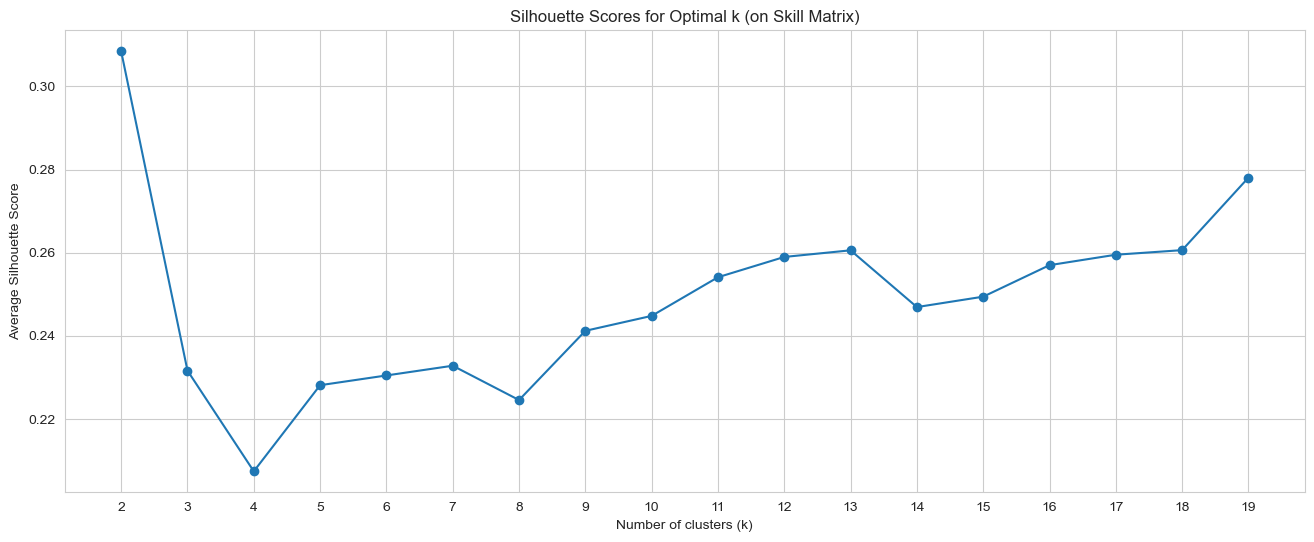


Optimal k based on highest Silhouette Score: 2


In [42]:
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

print("Calculating Silhouette Scores for different values of k...")
silhouette_scores = []
k_range = range(2, 20) # k must be >= 2 for silhouette score

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(skill_matrix)
    score = silhouette_score(skill_matrix, labels)
    silhouette_scores.append(score)
    print(f"k={k}, Silhouette Score: {score:.4f}")

# Plot the scores
plt.figure(figsize=(16, 6))
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Optimal k (on Skill Matrix)')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Find the k with the highest score
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nOptimal k based on highest Silhouette Score: {optimal_k}")

### Silhouette Score Analysis:

1. The data is easiest to split into two very broad groups (since k=2 has the highest score). This is not very useful, as it would likely just create a "Developer" cluster and an "Analyst" cluster, which isn't specific enough.

2. After the initial drop, the scores are all relatively low and close together (in the 0.22-0.27 range). This confirms that there are no perfectly distinct, clear-cut groups of skills.

##### This means we ***cannot rely on the metric alone to determine optimal K***. We therefore proceed to just using human interpretation for ***K = 5,6,7,8*** to see which number produces the **most logical and distinct job archetypes**. 



In [47]:
def profile_clusters(k):
    """Runs K-Means for a given k and prints the top skills for each cluster."""
    print(f"\n--- Profiling Clusters for k={k} ---")
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(skill_matrix)

    for i in range(k):
        print(f"\n--- Archetype {i} ---")
        # Filter the skill matrix for jobs in the current cluster
        cluster_skills = skill_matrix[df['cluster'] == i]
        
        # Calculate the percentage of jobs in the cluster that have each skill
        skill_prevalence = cluster_skills.mean().sort_values(ascending=False)
        
        print(f"Cluster Size: {len(cluster_skills)} jobs")
        print("Top 10 Defining Skills (% of jobs in cluster):")
        print((skill_prevalence.head(10) * 100).round(1).astype(str) + '%')

# --- Now test your top candidates ---
# Replace these with the best values from your silhouette score plot
profile_clusters(k=5)
profile_clusters(k=6)
profile_clusters(k=7)
profile_clusters(k=8)


--- Profiling Clusters for k=5 ---

--- Archetype 0 ---
Cluster Size: 678 jobs
Top 10 Defining Skills (% of jobs in cluster):
AI                  77.1%
Machine Learning    65.0%
Data Science        22.9%
Python              15.8%
Statistics           7.4%
AWS                  7.1%
TensorFlow           6.3%
PyTorch              5.8%
Azure                5.6%
Big Data             3.7%
dtype: object

--- Archetype 1 ---
Cluster Size: 758 jobs
Top 10 Defining Skills (% of jobs in cluster):
SQL                   99.7%
Power BI              30.9%
Excel                 22.3%
Azure                 21.9%
Data Visualisation    13.7%
Tableau               12.7%
AWS                   10.0%
JavaScript             9.8%
Git                    7.9%
Requests               7.3%
dtype: object

--- Archetype 2 ---
Cluster Size: 701 jobs
Top 10 Defining Skills (% of jobs in cluster):
Python                99.6%
SQL                   66.2%
AWS                   33.0%
Azure                 22.7%
Java       

## The Decision: <span style="color:blue">***k=8 is the Best Choice***</span>
##### While k=6 and k=7 both produce good results, k=8 provides the most distinct, strategically useful, and interpretable set of job archetypes.

### Why k=8 is the winner:

1. It successfully isolates the "Cloud Engineer." This is the most important improvement. At k=7, Data Engineering skills were mixed into a broader group. At k=8, Archetype 6 emerges as a pure Cloud & Data Engineer profile (Python, AWS, SQL, Spark, GCP). This is a high-value, distinct career path that IBM absolutely needs to understand.

2. It creates specific, actionable BI roles. It correctly separates the pure Power BI Analyst (Archetype 0) from the more general SQL Developer (Archetype 2). This allows for more targeted recommendations.

3. It cleanly identifies other key roles. It provides clear, understandable profiles for the ML/AI Specialist (Archetype 3), the Classic Data Scientist (Archetype 5), and the Excel-based Analyst/Economist (Archetype 4).

***

## Define Job Archetype Names for the 8 K-means Clusters

In [52]:
profile_clusters(k=8)


--- Profiling Clusters for k=8 ---

--- Archetype 0 ---
Cluster Size: 377 jobs
Top 10 Defining Skills (% of jobs in cluster):
Power BI              94.4%
SQL                   89.4%
Data Visualisation    47.5%
Tableau               39.5%
Python                37.1%
Azure                 36.1%
Excel                 23.6%
R                     17.5%
Statistics            13.8%
Data Science          12.7%
dtype: object

--- Archetype 1 ---
Cluster Size: 1814 jobs
Top 10 Defining Skills (% of jobs in cluster):
Data Science          6.4%
Python                5.5%
Azure                 5.5%
JavaScript            4.7%
Statistics            4.4%
Requests              4.1%
Economics             3.7%
AWS                   3.1%
Java                  2.8%
Data Visualisation    2.6%
dtype: object

--- Archetype 2 ---
Cluster Size: 576 jobs
Top 10 Defining Skills (% of jobs in cluster):
SQL           100.0%
Python         30.6%
Azure          17.2%
JavaScript     16.8%
Java           11.1%
Git    

## <span style="color:blue">***K=8*** **Potential Archetypes**:</span> 

1. #### Archetype 0: BI Visualization Specialist (Power BI Focus)
    * Core Skills: Power BI, SQL, Tableau
    * Cluster Size: 377 jobs

2. #### Archetype 1: (Low-Signal / General Business Roles)
    * This is your "catch-all" or "noise" cluster. You should exclude this group from your main archetype analysis but mention it as evidence of market diversity.
    * Cluster Size: 1814 jobs


3. #### Archetype 2: SQL Developer
    * Core Skills: SQL-first, with some Python and general development skills.
    * Cluster Size: 576 jobs

4. #### Archetype 3: Machine Learning & AI Specialist
    * Core Skills: Machine Learning, AI, Python, TensorFlow/PyTorch.
    * Cluster Size: 457 jobs

5. #### Archetype 4: Traditional Analyst / Economist (Excel-based)
    * Core Skills: Excel, with some SQL, Economics, and Forecasting.
    * Cluster Size: 435 jobs

6. #### Archetype 5: Classic Data Scientist (Stats & Modeling Focus)
   * Core Skills: Python, R, Statistics, SQL, Machine Learning.
   * Cluster Size: 368 jobs

7. #### Archetype 6: Cloud & Data Engineer
    * Core Skills: Python, AWS, SQL, Azure, Spark, GCP.
    * Cluster Size: 329 jobs

8. #### Archetype 7: AI Strategist
    * Core Skills: AI as a concept, but less focused on deep technical implementation.
    * Cluster Size: 240 jobs



In [55]:
# Create the k=8 cluster column:

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
df['kmeans_k8_clusters'] = kmeans.fit_predict(skill_matrix)

In [57]:
# --- Step 1: Define the mapping from the cluster number to our chosen name ---
# This dictionary is based on the above analysis of the k=8 results.

archetype_mapping = {
    0: 'BI Visualization Specialist (Power BI Focus)',
    1: 'Noise / General Business Role',  # The large, low-signal cluster
    2: 'SQL Developer',
    3: 'Machine Learning & AI Specialist',
    4: 'Traditional Analyst / Economist (Excel-based)',
    5: 'Classic Data Scientist (Stats & Modeling Focus)',
    6: 'Cloud & Data Engineer',
    7: 'AI Strategist'
}


# --- Step 2: Apply the mapping to create the new 'job_archetype' column ---

# Map the integer labels to the string names
df['kmeans_job_archetype'] = df['kmeans_k8_clusters'].map(archetype_mapping)


# --- Step 3: Verify the result ---
print(df['kmeans_job_archetype'].value_counts())

print("\nShowing a sample of the new column alongside the original cluster number:")
display(df[['kmeans_k8_clusters', 'kmeans_job_archetype']].head(10))

kmeans_job_archetype
Noise / General Business Role                      1814
SQL Developer                                       576
Machine Learning & AI Specialist                    457
Traditional Analyst / Economist (Excel-based)       435
BI Visualization Specialist (Power BI Focus)        377
Classic Data Scientist (Stats & Modeling Focus)     368
Cloud & Data Engineer                               329
AI Strategist                                       240
Name: count, dtype: int64

Showing a sample of the new column alongside the original cluster number:


kmeans_k8_clusters                          kmeans_job_archetype
0                   2                                 SQL Developer
1                   2                                 SQL Developer
2                   1                 Noise / General Business Role
3                   0  BI Visualization Specialist (Power BI Focus)
4                   0  BI Visualization Specialist (Power BI Focus)
5                   7                                 AI Strategist
6                   0  BI Visualization Specialist (Power BI Focus)
7                   2                                 SQL Developer
8                   7                                 AI Strategist
9                   7                                 AI Strategist

***

# --- Step 3: Create a Categorical Seniority Column

#### Without controlling for seniority model is likely to suffer from Omitted Variable Bias as:

##### 1. Senior roles naturally have higher salaries.

##### 2. Senior roles are also much more likely to require advanced skills (like your SuperSkill_Cloud_Engineering_MLOps).

Because of this, our model might be attributing the entire salary bump to the "Super-Skill," when in reality, a large part of that premium is simply because it's a senior-level job causing the coefficient for that Super-Skill to be likely overestimated.

#### By adding seniority as a control variable, we allow the model to answer a much more powerful question: ***"Holding seniority constant, what is the true, isolated salary impact of this Super-Skill?"***

In [28]:
# Order is important: check for manager/lead before senior to avoid misclassifying a "Senior Manager".
SENIOR_KEYWORDS = ['senior', 'sr.', 'lead', 'principal', 'staff']
JUNIOR_KEYWORDS = ['junior', 'jr.', 'graduate', 'entry', 'intern', 'assistant']
MANAGER_KEYWORDS = ['manager', 'head of', 'director', 'vp']

# --- Step 2: Create the Categorical Seniority Column ---
def assign_seniority(title):
    """Assigns a seniority level based on keywords in the job title."""
    if pd.isna(title):
        return 'Mid-Level' # Default
    
    title_lower = title.lower() #covnert title to lowercase
    
    # Check for manager level first
    for keyword in MANAGER_KEYWORDS:
        if keyword in title_lower:
            return 'Manager/Director'
            
    # Then check for senior level
    for keyword in SENIOR_KEYWORDS:
        if keyword in title_lower:
            return 'Senior'
            
    # Then check for junior level
    for keyword in JUNIOR_KEYWORDS:
        if keyword in title_lower:
            return 'Junior'
            
    # If no keywords are found, assign as Mid-Level
    return 'Mid-Level'

# Apply the function to your Job Title column
df['seniority'] = df['job_title'].apply(assign_seniority)

print("Created 'seniority' column. Value counts:")
print(df['seniority'].value_counts())

Created 'seniority' column. Value counts:
seniority
Mid-Level           2955
Senior              1023
Manager/Director     362
Junior               256
Name: count, dtype: int64


***
## --- Step 6: One-Hot Encoding (Region and Job Archetypes) ---

## 1. Determining Base Category for Regions: 


In [159]:
# Print value Counts for Region
print(df['region'].value_counts())

# Calculate and display the MEDIAN salary for each region, sorted
median_salary_by_region = df.groupby('region')['median_annual_salary_gbp'].median().sort_values(ascending=False)

print(f"\nMedian Salary by: {median_salary_by_region}")

region
London                      2124
South East (England)         478
Remote                       338
North West (England)         324
East of England              271
South West (England)         209
West Midlands (England)      204
Scotland                     181
East Midlands (England)      147
Yorkshire and The Humber     144
North East (England)          69
Wales                         57
Northern Ireland              49
Isle of Man                    1
Name: count, dtype: int64

Median Salary by: region
London                      57000.00
East Midlands (England)     55000.00
East of England             55000.00
Remote                      55000.00
Scotland                    55000.00
South East (England)        55000.00
Northern Ireland            54289.25
West Midlands (England)     52510.25
North West (England)        52439.30
North East (England)        52430.40
South West (England)        50257.21
Yorkshire and The Humber    50000.00
Isle of Man                 48100.0

### Base Category Choice: <span style="color:blue"> ***West Midlands (England)*** </span> 


##### Our Reasoning:

1. **Avoids Outliers:**

    * Looking at the value counts below, London is the biggest outlier in our dataset (2124 observations). We want to measure the "London premium," so it must be a variable in our model, not the baseline.
      
    * Remote is also a special, non-geographic category. we want to see if there is a "Remote work premium," so it also needs to be a variable.

2. **It's a "Typical" Region:**

    * The West Midlands is a major economic region but isn't an extreme outlier like London. It has a substantial number of observations (204), making it a stable and representative baseline.
      
    * Choosing a "typical" region like this makes our interpretation more powerful and intuitive.

3. **It Makes our Story Clearer:**

    * Enables us to make clear, compelling statements like:
      

    ***"Compared to a job in the West Midlands, an identical job in London is associated with a 15% salary premium."***

    ***"Compared to a job in the West Midlands, a Remote role is associated with an 8% salary premium."***

## 2. Determining Base Category for Job Archetypes: 

In [161]:
# Value counts for Job Archetype
print(df['kmeans_job_archetype'].value_counts())

# Calculate and display the MEDIAN salary for each archetype, sorted
median_salary_by_archetype = df.groupby('kmeans_job_archetype')['median_annual_salary_gbp'].median().sort_values(ascending=False)

print(f"\nMedian Salary by: {median_salary_by_archetype}")


kmeans_job_archetype
Noise / General Business Role                      1814
SQL Developer                                       576
Machine Learning & AI Specialist                    457
Traditional Analyst / Economist (Excel-based)       435
BI Visualization Specialist (Power BI Focus)        377
Classic Data Scientist (Stats & Modeling Focus)     368
Cloud & Data Engineer                               329
AI Strategist                                       240
Name: count, dtype: int64

Median Salary by: kmeans_job_archetype
AI Strategist                                      61097.715
Cloud & Data Engineer                              60000.000
Machine Learning & AI Specialist                   60000.000
Classic Data Scientist (Stats & Modeling Focus)    55820.000
BI Visualization Specialist (Power BI Focus)       55000.000
Noise / General Business Role                      55000.000
SQL Developer                                      55000.000
Traditional Analyst / Economist (Excel


### Archetype Base Category Choice: <span style="color:blue"> ***Traditional Analyst / Economist (Excel-based)*** </span> 

##### Our Reasoning:

##### **The Evidence:** The results above show that the Traditional Analyst / Economist (Excel-based) has the lowest median salary (£50,000) of all the defined archetypes.

##### **Why This Confirms our Choice:** This is perfect. It provides direct, data-driven evidence that this archetype is the "ground floor" or starting point of the data career ladder. By setting this lowest-paid, foundational role as our baseline, the coefficient for every other archetype in your regression will now represent the clear, quantifiable "upskilling premium" — exactly the story we want to tell.

1. **More Powerful Narrative:**

    * It frames the regression results as a direct measure of the economic value of upskilling.
  
    * Each coefficient for the other archetypes now represents the salary premium gained by progressing from this more foundational role to a more specialised one.


2. **Provides a Logical and Intuitive Baseline:**

    * This archetype, defined by traditional tools like Excel, represents a common career starting point.
      
    * Comparing other, more advanced roles to this "ground floor" is more logical and easier to interpret than comparing them to a vague "general business" category.

3. **Generates More Actionable Insights for IBM:**

    * The results directly answer the question, ***"What is the return on investment for a learner who upskills from a traditional analyst role?"***
      
    * This allows for highly specific and compelling recommendations for the SkillsBuild program.
      
4. **Ensures a Stable and Coherent Comparison:**

    * Unlike the "Noise/ General Business Role  " cluster (which is a mix of many different, unrelated roles), the "Traditional Analyst" is a well-defined and homogenous group, making it a more statistically robust baseline for comparisons.
  
#### ***"We chose the 'Traditional Analyst' as our baseline for comparison. As you can see from the descriptive statistics, this archetype has one of the lowest median salaries at £50,000, reinforcing its position as a foundational or at-risk role, which makes it the perfect starting point to measure the value of upskilling."***

## 3. Determining Base Category for Seniority: 

In [63]:
# Value counts for Job Archetype
print(df['seniority'].value_counts())

# Calculate and display the MEDIAN salary for each archetype, sorted
median_salary_by_seniority = df.groupby('seniority')['median_annual_salary_gbp'].median().sort_values(ascending=False)

print(f"\nMedian Salary by: {median_salary_by_seniority}")

seniority
Mid-Level           2955
Senior              1023
Manager/Director     362
Junior               256
Name: count, dtype: int64

Median Salary by: seniority
Senior              60000.000
Manager/Director    59258.335
Mid-Level           55000.000
Junior              45000.000
Name: median_annual_salary_gbp, dtype: float64



### Seniority Base Category Choice: <span style="color:blue"> ***"Junior"*** </span> 

#### Our Reasoning:

##### This frames our entire analysis around ***career progression***. By setting the "Junior" level as the baseline, the coefficient for every other seniority level in our regression model will have a more direct and powerful interpretation:

* The coefficient for *Seniority_Mid-Level* will represent the average salary premium for moving from a Junior to a Mid-Level role.
  
* The coefficient for *Seniority_Senior* will represent the premium for moving from a Junior to a Senior role.

##### This allows us to tell a compelling story about the economic value of experience and upskilling, which is perfectly aligned with the dissertation's theme as we are directly quantifying the "rungs" of the career ladder.
***

<span style="color:purple">
    
## NOTE: Why we don't control for Degree Level (for "Limitations" chapter):

 ***"Our model does not explicitly control for the required educational level (e.g., Bachelor's, Master's, PhD) of each role. This is due to the high degree of inconsistency and missing data for this variable within the raw job descriptions. While we hypothesize that a portion of the salary premium for archetypes like the 'Machine Learning Specialist' is attributable to a higher prevalence of PhD requirements, we determined that the job_archetype and seniority variables already serve as strong proxies for this effect. Future research with more structured data could further disentangle these factors."***


### Example Draft for "Limitations" Section:

*"While our regression model controls for job archetype, region, seniority, and a rich set of 'Super-Skills', we acknowledge that it does not capture all the factors that determine salary. Two key omitted variables are the required level of formal education and the specific years of experience demanded by the role.*

*Our seniority variable, derived from keywords in the job title (e.g., 'Junior', 'Senior', 'Lead'), serves as a strong proxy for the required experience level. However, we did not include a variable for educational attainment (e.g., Bachelor's, Master's, PhD) due to significant data quality issues. The requirement was often ambiguously worded (e.g., "Master's preferred") or missing entirely from the job descriptions, making it impossible to create a reliable, consistent feature across the dataset.*

*We hypothesize that a portion of the salary premium we observe for archetypes like the 'Machine Learning Specialist' is attributable to a higher prevalence of PhD requirements in those roles. A valuable avenue for future research would be to use a more structured dataset to disentangle the specific salary impacts of skills, experience, and educational credentials."*
</span>

***

In [80]:
# --- One-Hot Encode Region ---
region_dummies = pd.get_dummies(df['region'], prefix='region')
region_col_to_drop = 'region_West Midlands (England)'
if region_col_to_drop in region_dummies.columns:
    region_dummies.drop(columns=region_col_to_drop, inplace=True)
    
print(f"Created region dummies with shape: {region_dummies.shape}")
display(region_dummies.head())

# --- One-Hot Encode Seniority ---
seniority_dummies = pd.get_dummies(df['seniority'], prefix='seniority')
seniority_col_to_drop = 'seniority_Junior'
if seniority_col_to_drop in seniority_dummies.columns:
    seniority_dummies.drop(columns=seniority_col_to_drop, inplace=True)
    
print(f"Created seniority dummies with shape: {region_dummies.shape}")
display(seniority_dummies.head())


# --- One-Hot Encode K-means Job Archetypes ---
archetype_dummies = pd.get_dummies(df['kmeans_job_archetype'], prefix='kmeans_job_archetype')
archetype_col_to_drop = 'kmeans_job_archetype_Traditional Analyst / Economist (Excel-based)'
if archetype_col_to_drop in archetype_dummies.columns:
    archetype_dummies.drop(columns=archetype_col_to_drop, inplace=True)
    
print(f"Created K-means Job Archetype dummies with shape: {archetype_dummies.shape}")
display(archetype_dummies.head())

Created region dummies with shape: (4596, 13)


region_East Midlands (England)  region_East of England  region_Isle of Man  \
0                            True                   False               False   
1                            True                   False               False   
2                            True                   False               False   
3                            True                   False               False   
4                            True                   False               False   

   region_London  region_North East (England)  region_North West (England)  \
0          False                        False                        False   
1          False                        False                        False   
2          False                        False                        False   
3          False                        False                        False   
4          False                        False                        False   

   region_Northern Ireland  region_Remote  region_Scotland  \
0                    False          False            False   
1                    False          False            False   
2                    False          False            False   
3                    False          False            False   
4                    False          False            False   

   region_South East (England)  region_South West (England)  region_Wales  \
0                        False                        False         False   
1                        False                        False         False   
2                        False                        False         False   
3                        False                        False         False   
4                        False                        False         False   

   region_Yorkshire and The Humber  
0                            False  
1                            False  
2                            False  
3                            False  
4                            False

Created seniority dummies with shape: (4596, 13)


seniority_Manager/Director  seniority_Mid-Level  seniority_Senior
0                       False                 True             False
1                       False                 True             False
2                       False                 True             False
3                       False                 True             False
4                       False                 True             False

Created K-means Job Archetype dummies with shape: (4596, 7)


kmeans_job_archetype_AI Strategist  \
0                               False   
1                               False   
2                               False   
3                               False   
4                               False   

   kmeans_job_archetype_BI Visualization Specialist (Power BI Focus)  \
0                                              False                   
1                                              False                   
2                                              False                   
3                                               True                   
4                                               True                   

   kmeans_job_archetype_Classic Data Scientist (Stats & Modeling Focus)  \
0                                              False                      
1                                              False                      
2                                              False                      
3                                              False                      
4                                              False                      

   kmeans_job_archetype_Cloud & Data Engineer  \
0                                       False   
1                                       False   
2                                       False   
3                                       False   
4                                       False   

   kmeans_job_archetype_Machine Learning & AI Specialist  \
0                                              False       
1                                              False       
2                                              False       
3                                              False       
4                                              False       

   kmeans_job_archetype_Noise / General Business Role  \
0                                              False    
1                                              False    
2                                               True    
3                                              False    
4                                              False    

   kmeans_job_archetype_SQL Developer  
0                                True  
1                                True  
2                               False  
3                               False  
4                               False

***
## Region-Archetype Summary Table

In [83]:
# Create the cross-tabulation of Region vs. Job Archetype
region_archetype_counts = pd.crosstab(
    index=df['region'],
    columns=df['kmeans_job_archetype']
)

print("--- Summary Table: Job Archetype Counts by Region ---")
display(region_archetype_counts)

--- Summary Table: Job Archetype Counts by Region ---


kmeans_job_archetype      AI Strategist  \
region                                    
East Midlands (England)               9   
East of England                      21   
Isle of Man                           0   
London                              120   
North East (England)                  4   
North West (England)                  6   
Northern Ireland                      0   
Remote                               31   
Scotland                             14   
South East (England)                 13   
South West (England)                  9   
Wales                                 1   
West Midlands (England)               7   
Yorkshire and The Humber              5   

kmeans_job_archetype      BI Visualization Specialist (Power BI Focus)  \
region                                                                   
East Midlands (England)                                             10   
East of England                                                     26   
Isle of Man                                                          0   
London                                                             136   
North East (England)                                                 8   
North West (England)                                                35   
Northern Ireland                                                     4   
Remote                                                              26   
Scotland                                                            17   
South East (England)                                                37   
South West (England)                                                27   
Wales                                                                7   
West Midlands (England)                                             33   
Yorkshire and The Humber                                            11   

kmeans_job_archetype      Classic Data Scientist (Stats & Modeling Focus)  \
region                                                                      
East Midlands (England)                                                 8   
East of England                                                        10   
Isle of Man                                                             0   
London                                                                245   
North East (England)                                                    6   
North West (England)                                                   19   
Northern Ireland                                                        3   
Remote                                                                 14   
Scotland                                                                9   
South East (England)                                                   34   
South West (England)                                                    5   
Wales                                                                   1   
West Midlands (England)                                                11   
Yorkshire and The Humber                                                3   

kmeans_job_archetype      Cloud & Data Engineer  \
region                                            
East Midlands (England)                       8   
East of England                              17   
Isle of Man                                   0   
London                                      187   
North East (England)                          3   
North West (England)                         17   
Northern Ireland                              4   
Remote                                       19   
Scotland                                     16   
South East (England)                         29   
South West (England)                         14   
Wales                                         2   
West Midlands (England)                       8   
Yorkshire and The Humber                      5   

kmeans_job_archetype      Machine Learning & AI Specialist  \
region        


--- Summary Table: Job Archetype as a Percentage of Each Region's Total Jobs ---


kmeans_job_archetype      AI Strategist  \
region                                    
East Midlands (England)             6.1   
East of England                     7.7   
Isle of Man                         0.0   
London                              5.6   
North East (England)                5.8   
North West (England)                1.9   
Northern Ireland                    0.0   
Remote                              9.2   
Scotland                            7.7   
South East (England)                2.7   
South West (England)                4.3   
Wales                               1.8   
West Midlands (England)             3.4   
Yorkshire and The Humber            3.5   

kmeans_job_archetype      BI Visualization Specialist (Power BI Focus)  \
region                                                                   
East Midlands (England)                                            6.8   
East of England                                                    9.6   
Isle of Man                                                        0.0   
London                                                             6.4   
North East (England)                                              11.6   
North West (England)                                              10.8   
Northern Ireland                                                   8.2   
Remote                                                             7.7   
Scotland                                                           9.4   
South East (England)                                               7.7   
South West (England)                                              12.9   
Wales                                                             12.3   
West Midlands (England)                                           16.2   
Yorkshire and The Humber                                           7.6   

kmeans_job_archetype      Classic Data Scientist (Stats & Modeling Focus)  \
region                                                                      
East Midlands (England)                                               5.4   
East of England                                                       3.7   
Isle of Man                                                           0.0   
London                                                               11.5   
North East (England)                                                  8.7   
North West (England)                                                  5.9   
Northern Ireland                                                      6.1   
Remote                                                                4.1   
Scotland                                                              5.0   
South East (England)                                                  7.1   
South West (England)                                                  2.4   
Wales                                                                 1.8   
West Midlands (England)                                               5.4   
Yorkshire and The Humber                                              2.1   

kmeans_job_archetype      Cloud & Data Engineer  \
region                                            
East Midlands (England)                     5.4   
East of England                             6.3   
Isle of Man                                 0.0   
London                                      8.8   
North East (England)                        4.3   
North West (England)                        5.2   
Northern Ireland                            8.2   
Remote                                      5.6   
Scotland                                    8.8   
South East (England)                        6.1   
South West (England)                        6.7   
Wales                                       3.5   
West Midlands (England)                     3.9   
Yorkshire and The Humber                    3.5   

kmeans_job_archetype      Machine Learning & AI Specialist  \
region        

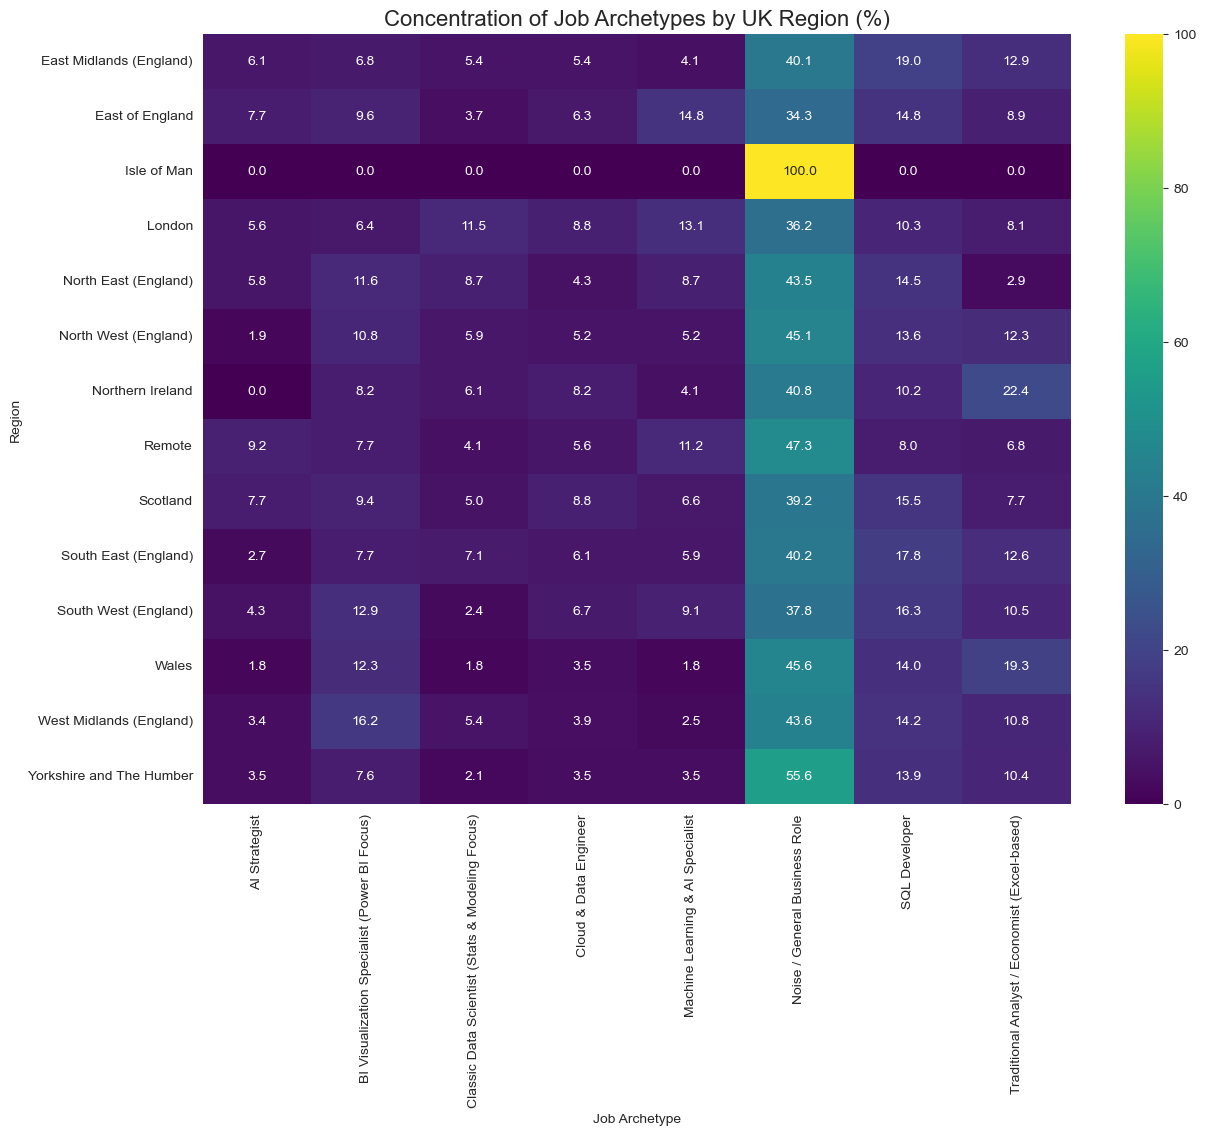

In [85]:
# Create the cross-tabulation, but normalize by row to get percentages
region_archetype_percentages = pd.crosstab(
    index=df['region'],
    columns=df['kmeans_job_archetype'],
    normalize='index' # This is the key parameter
).mul(100).round(1) # Convert to percentage and round

print("\n--- Summary Table: Job Archetype as a Percentage of Each Region's Total Jobs ---")
display(region_archetype_percentages)

# --- Optional: Create a Heatmap for your Presentation ---
# This is a great visual for a slide
plt.figure(figsize=(14, 10))
sns.heatmap(region_archetype_percentages, cmap="viridis", annot=True, fmt=".1f")
plt.title('Concentration of Job Archetypes by UK Region (%)', fontsize=16)
plt.ylabel('Region')
plt.xlabel('Job Archetype')
plt.show()

### How to Interpret and Use Job Concentration by Archetype Chart:
#### 1. Look for Hotspots: 
* The percentage table and the heatmap will immediately show you the "hotspots."
  
* You'll be able to see, for example, that London has a much higher percentage of "AI Strategist" roles than any other region, while the North West might have the highest concentration of "BI Visualization Specialists."

#### 2. Strengthen Your Recommendations: 

This table provides direct evidence for your regional recommendations to IBM. You can now say with confidence:

***"Our analysis shows that the 'Cloud & Data Engineer' archetype makes up 25% of all data jobs in London, but only 8% in the North West. Therefore, the 'High-Value Cloud Engineer' pathway should be prioritized for deployment in London-based library partnerships."***

***
## --- Step 7: Principal Component Analysis (PCA) ---

* ##### Purpose of using Principal Component Analysis (PCA) is to solve the problem of ***collinearity*** that Sekyu warned us about. 

* ##### With PCA we take the large, messy, and correlated one-hot encoded skill matrix that and transform it into a small number of clean, uncorrelated "Super-Skill" components that Pengjin suggested.

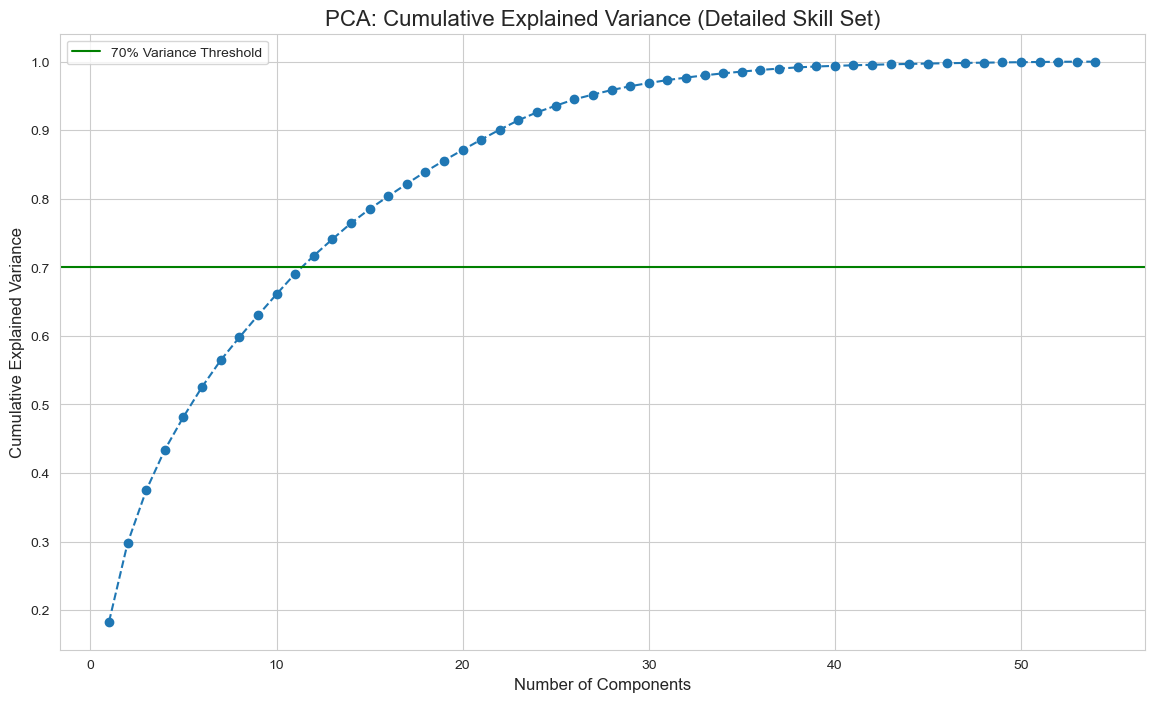


Number of components to explain ~70% of variance: 12


In [89]:
# Apply PCA to the detailed skill matrix
pca = PCA()
pca.fit(skill_matrix)

# Calculate the cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the explained variance to help choose the number of components
plt.figure(figsize=(14, 8))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('PCA: Cumulative Explained Variance (Detailed Skill Set)', fontsize=16)
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.axhline(y=0.7, color='g', linestyle='-', label='70% Variance Threshold')
plt.grid(True)
plt.legend()
plt.show()

# Find the number of components that explain ~70% of the variance
# 70% is a good target for high-dimensional, sparse data like this.
n_components_70_var = np.where(cumulative_variance >= 0.7)[0][0] + 1
print(f"\nNumber of components to explain ~70% of variance: {n_components_70_var}")

In [91]:
# Choose the number of components based on the analysis above
N_COMPONENTS = n_components_70_var 

pca = PCA(n_components=N_COMPONENTS)
skill_pca_components = pca.fit_transform(skill_matrix)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(skill_pca_components, 
                      columns=[f'PC_{i+1}' for i in range(N_COMPONENTS)],
                      index=df.index)

# Create a "loadings" dataframe to interpret the components
loadings = pd.DataFrame(pca.components_.T, columns=pca_df.columns, index=skill_matrix.columns)

print("\n--- Top Defining Skills for each Principal Component ---")
for col in loadings.columns:
    print(f"\n--- {col} ---")
    top_positive_skills = loadings[col].sort_values(ascending=False).head(6)
    print(top_positive_skills)


--- Top Defining Skills for each Principal Component ---

--- PC_1 ---
Python              0.542237
SQL                 0.450342
Machine Learning    0.284071
Data Science        0.268126
Statistics          0.257551
R                   0.243039
Name: PC_1, dtype: float64

--- PC_2 ---
SQL                   0.555412
Power BI              0.271316
Excel                 0.186876
Azure                 0.131327
Tableau               0.117341
Data Visualisation    0.096646
Name: PC_2, dtype: float64

--- PC_3 ---
Excel                 0.430453
Statistics            0.358708
R                     0.241276
Data Visualisation    0.230823
Power BI              0.209218
Data Science          0.204306
Name: PC_3, dtype: float64

--- PC_4 ---
AI                    0.484701
Power BI              0.365863
Azure                 0.276834
Machine Learning      0.267510
SQL                   0.246311
Data Visualisation    0.176662
Name: PC_4, dtype: float64

--- PC_5 ---
SQL                 0.559149
AI 

### Assigning Labels to SuperSkill Principle Components

In [94]:
# --- Name principle components based on the loadings ---

#We decided on names based on the skills in each PC
component_names = {
    'PC_1': 'SuperSkill_Basic_Data_Science', # (Core emphasis on coding (Python/R/SQL) plus foundational ML/statistics.)
    'PC_2': 'SuperSkill_BI_DataViz', # (Heavy on SQL-based reporting and modern BI tools.)
    'PC_3': 'SuperSkill_Statistical_Analysis_Reporting', # (Spreadsheet-centric analytics with statistical modeling and basic viz.)
    'PC_4': 'SuperSkill_Cloud-Enabled_AI_BI', # (Blends cloud (Azure) BI tooling with AI/ML capabilities.)
    'PC_5': 'SuperSkill_SQL_Analytics_&_Automation', # (SQL at the core, augmented with AI/ML and scripting (JS).)
    'PC_6': 'SuperSkill_AI_Cloud_Excel', # (Excel + AI/ML prototyping, with cloud (AWS) exposure.)
    'PC_7': 'SuperSkill_Cloud_Augmented_Analysis', # (Mix of Excel/data-science methods delivered via AWS infrastructure.)
    'PC_8': 'SuperSkill_Cloud_Analytics_Econometrics', # (Cloud platform + statistical/econometric modeling (R/Economics).)
    'PC_9': 'SuperSkill_Python_Data_Products', # (Python ecosystem focused on building data-centric applications)
    'PC_10': 'SuperSkill_Cloud_Engineering_MLOps', # (Cloud infra (AWS), versioning (Git), plus monitoring/visualization for ML ops.)
    'PC_11': 'SuperSkill_BI_&_DataViz', # (Heavy on SQL-based reporting and modern BI tools.)
    'PC_12': 'SuperSkill_R_StatScience_&_BI', # (R/SAS-driven statistical modeling integrated with cloud & BI tools.)
}

# Rename the columns in your pca_df with your team's chosen names
final_component_names = {f'PC_{i+1}': name for i, name in enumerate(component_names.values()) if i < N_COMPONENTS}
pca_df.rename(columns=final_component_names, inplace=True)

print("\nRenamed PCA columns:")
display(pca_df.head())


Renamed PCA columns:


SuperSkill_Basic_Data_Science  SuperSkill_BI_DataViz  \
0                       0.615556               0.096327   
1                       0.615556               0.096327   
2                      -0.594345              -0.041538   
3                       0.196434               0.984717   
4                       0.184440               0.804152   

   SuperSkill_Statistical_Analysis_Reporting  SuperSkill_Cloud-Enabled_AI_BI  \
0                                  -0.598018                        0.007493   
1                                  -0.598018                        0.007493   
2                                  -0.027883                       -0.113718   
3                                  -0.240444                        0.767624   
4                                  -0.298285                        0.493275   

   SuperSkill_SQL_Analytics_&_Automation  SuperSkill_AI_Cloud_Excel  \
0                               0.928320                   0.497008   
1                               0.928320                   0.497008   
2                              -0.040580                  -0.084370   
3                              -0.198735                  -0.273994   
4                              -0.080941                  -0.074659   

   SuperSkill_Cloud_Augmented_Analysis  \
0                            -0.319807   
1                            -0.319807   
2                            -0.086662   
3                             0.030810   
4                             0.049684   

   SuperSkill_Cloud_Analytics_Econometrics  SuperSkill_Python_Data_Products  \
0                                 0.041788                         0.322625   
1                                 0.041788                         0.322625   
2                                -0.023403                        -0.024261   
3                                 0.589985                         0.041711   
4                                -0.166118                         0.010315   

   SuperSkill_Cloud_Engineering_MLOps  SuperSkill_BI_&_DataViz  \
0                           -0.748862                -0.320583   
1                           -0.748862                -0.320583   
2                            0.040882                 0.018408   
3                            0.280819                -0.122023   
4                           -0.025484                 0.547038   

   SuperSkill_R_StatScience_&_BI  
0                      -0.562958  
1                      -0.562958  
2                       0.020780  
3                      -0.292294  
4                       0.352668

***
## --- Step 8: Export Enriched Dataset & Final Regression Dataset---

In [98]:
# --- Create the final modelling dataset: final_modelling_dataset.csv ---

# Assemble the list of dataframes for the final modelling dataset (for regression)
regression_df_list = [
    df[['median_annual_salary_gbp']], # The target variable
    pca_df,                             # The "Super-Skill" features
    region_dummies,                     # The location features
    archetype_dummies,                   # K-means job archetype features
    seniority_dummies                 
]
# df: original dataframe, now with 'job_archetype' and 'technical_skills' columns
# pca_df: The dataframe with named "Super-Skill" PCA components
# region_dummies: The dataframe with the one-hot encoded regions
# archetype_dummies: The dataframe with the one-hot encoded archetypes

# Concatenate
final_regression_dataset = pd.concat(regression_df_list, axis=1)
final_regression_dataset.dropna(subset=['median_annual_salary_gbp'], inplace=True)

# Export final_modelling_dataset.csv
final_regression_dataset.to_csv('final_modelling_dataset.csv', index=False)
print(f"Saved 'final_modelling_dataset.csv' for modeling. Shape: {final_regression_dataset.shape}")


# --- File 2: Create the enriched, detailed dataset for manual checking / marking ---

# Assemble the list of dataframes for the full analysis file
# We start with the original dataframe and add the new features
full_analysis_df_list = [
    df,       # Your original dataframe with all text columns + new archetype/skill list columns
    pca_df    # The "Super-Skill" PCA component scores
]

# Concatenate for the full analysis dataset
# Note: We merge on index to ensure rows align correctly
full_analysis_dataset = pd.concat(full_analysis_df_list, axis=1)
full_analysis_dataset.dropna(subset=['median_annual_salary_gbp'], inplace=True)

# Save the file for the assessor
full_analysis_dataset.to_csv('master_enriched_job_listings_dataset.csv', index=False)
print(f"Saved 'master_enriched_job_listings_dataset.csv' for exploration and validation. Shape: {full_analysis_dataset.shape}")

Saved 'final_modelling_dataset.csv' for modeling. Shape: (4596, 36)
Saved 'master_enriched_job_listings_dataset.csv' for exploration and validation. Shape: (4596, 42)
